In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr


In [46]:
# excel_file = r'e:\lakes\LMJD\lake_level_change_on_LMJD.xlsx'  # 替换为你的 Excel 文件路径
# df = pd.read_excel(excel_file)
# # 保存为 CSV 文件
# csv_file = r"e:\lakes\LMJD\lake_level_change_on_LMJD.csv"   # 替换为输出 CSV 文件的路径
# df.to_csv(csv_file, index=False, encoding='utf-8')  # index=False 防止保存行索引

In [49]:
# 读取 CSV 文件
df2 = pd.read_csv(r'e:\lakes\NamCo\readout\output_file.csv')  
df1 = pd.read_csv(r'e:\lakes\NamCo\DAHITI_water_level.csv') 

# 确保日期列是datetime格式
df1['date'] = pd.to_datetime(df1['date'])  # 假设 'date' 列是日期列
df2['date'] = pd.to_datetime(df2['date'])

# 提取年份和月份，添加到每个数据集中
df1['year_month'] = df1['date'].dt.to_period('M')  # 'M' 为月度
df2['year_month'] = df2['date'].dt.to_period('M')

# 按年份和月份分组并计算每个月的平均值
df1_monthly = df1.groupby('year_month').agg({'elev': 'mean'}).reset_index()  # 假设需要计算的列是 'value'
df2_monthly = df2.groupby('year_month').agg({'elev': 'mean'}).reset_index()  # 假设需要计算的列是 'value'

# 合并两个按月份分组的数据集
merged_df = pd.merge(df1_monthly, df2_monthly, on='year_month', suffixes=('_df1', '_df2'))

# 计算每个月的变化量和变化率
merged_df['change_elev_df1'] = merged_df['elev_df1'].diff()  # 计算 df1 中的变化量
merged_df['change_elev_df2'] = merged_df['elev_df2'].diff()  # 计算 df2 中的变化量

# # 计算变化率（百分比变化）
# merged_df['rate_elev_df1'] = merged_df['change_elev_df1'] / merged_df['elev_df1'].shift(1) * 100
# merged_df['rate_elev_df2'] = merged_df['change_elev_df2'] / merged_df['elev_df2'].shift(1) * 100

# # 删除首行 NaN 数据（因为差分计算导致第一行是 NaN）
# merged_df = merged_df.dropna()

# 打印最终结果
print(merged_df)
# 输出到 CSV 文件
output_file = r'e:\lakes\NamCo\merged_data.csv'  # 输出的文件路径
merged_df.to_csv(output_file, index=False)  # 保存为 CSV 文件，不包含索引列

   year_month   elev_df1    elev_df2  change_elev_df1  change_elev_df2
0     2019-02  4723.1680  4725.60365              NaN              NaN
1     2019-05  4723.3225  4725.61485           0.1545          0.01120
2     2019-08  4723.6840  4725.84670           0.3615          0.23185
3     2019-11  4723.6690  4725.92310          -0.0150          0.07640
4     2020-05  4723.3780  4725.74400          -0.2910         -0.17910
5     2020-08  4723.8975  4726.16450           0.5195          0.42050
6     2020-11  4723.7810  4726.03875          -0.1165         -0.12575
7     2021-02  4723.4760  4725.77540          -0.3050         -0.26335
8     2021-05  4723.4060  4725.71750          -0.0700         -0.05790
9     2021-08  4723.7080  4725.97800           0.3020          0.26050
10    2021-11  4723.9700  4726.02600           0.2620          0.04800
11    2022-05  4723.5930  4725.92100          -0.3770         -0.10500
12    2022-08  4723.8060  4726.11100           0.2130          0.19000
13    

In [56]:
# 相关性计算（皮尔逊相关系数）
correlation_df1_df2 = pearsonr(merged_df['elev_df1'], merged_df['elev_df2'])[0]
correlation_change_df1_df2 = pearsonr(merged_df['change_elev_df1'], merged_df['change_elev_df2'])[0]

# 计算 RMSE 和 R²
# 基于原始数据
rmse_df1_df2 = np.sqrt(mean_squared_error(merged_df['elev_df1'], merged_df['elev_df2']))
r2_df1_df2 = r2_score(merged_df['elev_df1'], merged_df['elev_df2'])

# 基于变化量数据
rmse_change_df1_df2 = np.sqrt(mean_squared_error(merged_df['change_elev_df1'], merged_df['change_elev_df2']))
r2_change_df1_df2 = r2_score(merged_df['change_elev_df1'], merged_df['change_elev_df2'])

# 输出相关性、RMSE 和 R²
print("Correlation (Original Data):", correlation_df1_df2)
print("Correlation (Change Data):", correlation_change_df1_df2)

print("RMSE (Original Data):", rmse_df1_df2)
print("R² (Original Data):", r2_df1_df2)

print("RMSE (Change Data):", rmse_change_df1_df2)
print("R² (Change Data):", r2_change_df1_df2)

Correlation (Original Data): 0.9267323581831028
Correlation (Change Data): 0.9137479649219571
RMSE (Original Data): 2.2447879659795884
R² (Original Data): -124.8717887818845
RMSE (Change Data): 0.11612371508848232
R² (Change Data): 0.8131129257909672


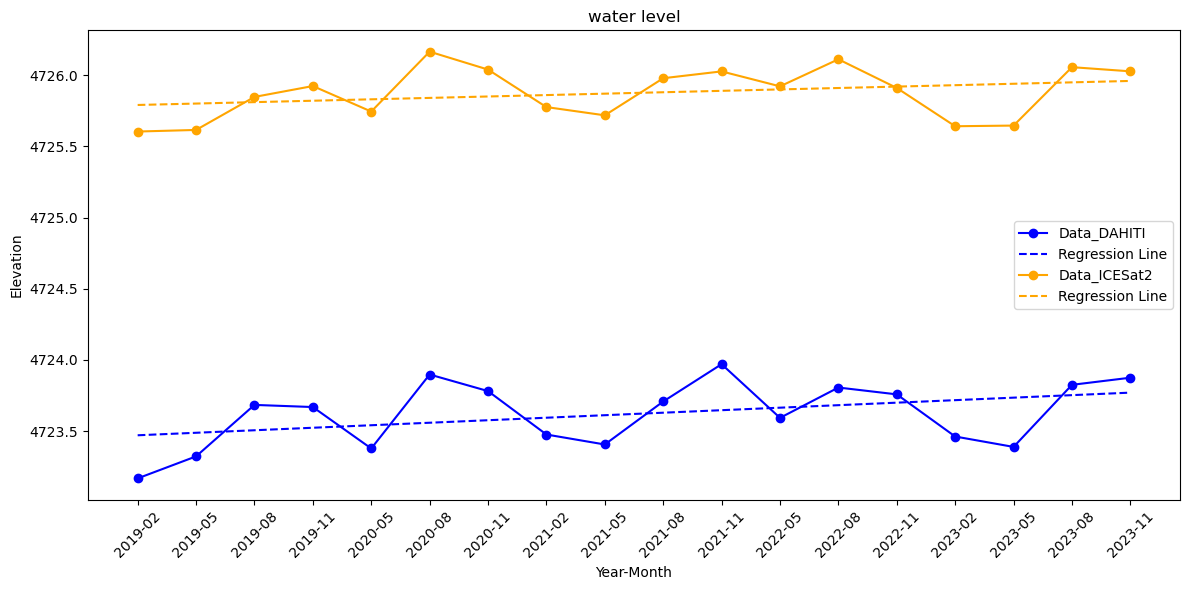

In [50]:
# 基于原始数据点的线性回归
plt.figure(figsize=(12, 6))

X1 = np.array(range(len(merged_df)))  # 使用行号作为 x 轴数据
y1_df1 = merged_df['elev_df1'].values
y1_df2 = merged_df['elev_df2'].values

# 使用线性回归计算拟合
regressor1_df1 = LinearRegression().fit(X1.reshape(-1, 1), y1_df1)
regressor1_df2 = LinearRegression().fit(X1.reshape(-1, 1), y1_df2)

# 预测回归线
y_pred_df1 = regressor1_df1.predict(X1.reshape(-1, 1))
y_pred_df2 = regressor1_df2.predict(X1.reshape(-1, 1))

# 绘制原始数据点及其回归线
plt.plot(merged_df['year_month'].astype(str), y1_df1, label='Data_DAHITI', color='blue', marker='o')
plt.plot(merged_df['year_month'].astype(str), y_pred_df1, label='Regression Line', color='blue', linestyle='--')
plt.plot(merged_df['year_month'].astype(str), y1_df2, label='Data_ICESat2', color='orange', marker='o')
plt.plot(merged_df['year_month'].astype(str), y_pred_df2, label='Regression Line', color='orange', linestyle='--')
plt.xlabel('Year-Month')
plt.ylabel('Elevation')
plt.title('water level')
plt.legend()

# 保存或展示第一个图
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

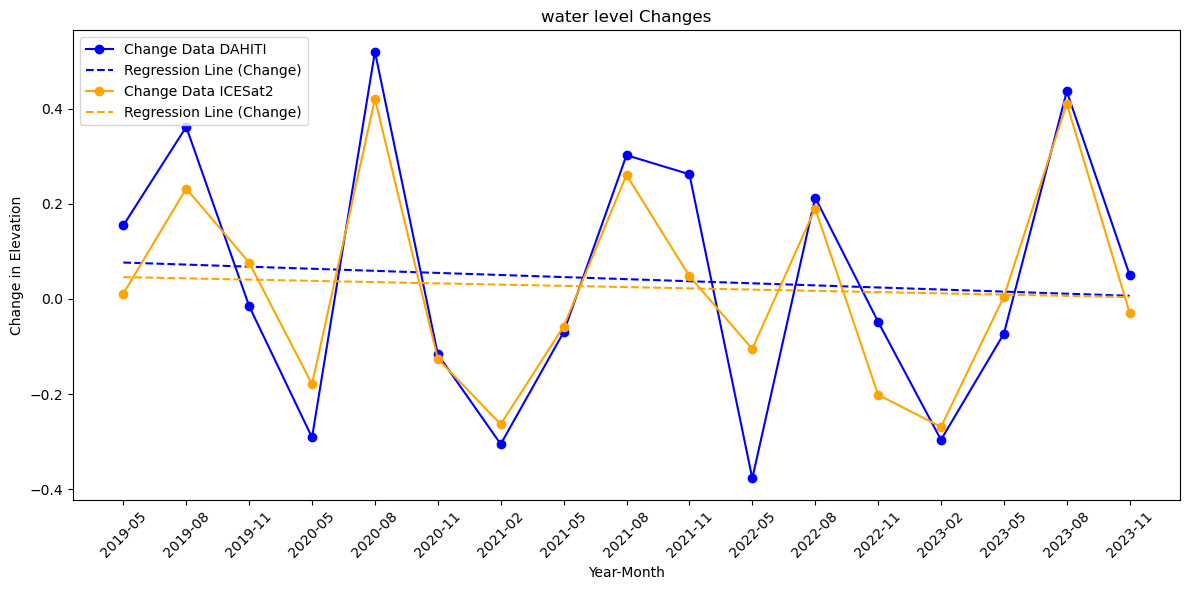

In [51]:
# 基于变化量的线性回归
plt.figure(figsize=(12, 6))

X2 = np.array(range(1, len(merged_df)))  # 使用行号作为 x 轴数据，跳过第一行 NaN
y2_df1_change = merged_df['change_elev_df1'].dropna().values
y2_df2_change = merged_df['change_elev_df2'].dropna().values

# 使用线性回归计算拟合
regressor2_df1 = LinearRegression().fit(X2.reshape(-1, 1), y2_df1_change)
regressor2_df2 = LinearRegression().fit(X2.reshape(-1, 1), y2_df2_change)

# 预测回归线
y_pred_df1_change = regressor2_df1.predict(X2.reshape(-1, 1))
y_pred_df2_change = regressor2_df2.predict(X2.reshape(-1, 1))

# 绘制变化量数据点及其回归线
plt.plot(merged_df['year_month'].astype(str).iloc[1:], y2_df1_change, label='Change Data DAHITI', color='blue', marker='o')
plt.plot(merged_df['year_month'].astype(str).iloc[1:], y_pred_df1_change, label='Regression Line (Change)', color='blue', linestyle='--')
plt.plot(merged_df['year_month'].astype(str).iloc[1:], y2_df2_change, label='Change Data ICESat2', color='orange', marker='o')
plt.plot(merged_df['year_month'].astype(str).iloc[1:], y_pred_df2_change, label='Regression Line (Change)', color='orange', linestyle='--')
plt.xlabel('Year-Month')
plt.ylabel('Change in Elevation')
plt.title('water level Changes')
plt.legend()

# 保存或展示第二个图
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 计算 R^2 和均方误差 (MSE)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print(f"R^2: {r2}")
print(f"均方误差 (MSE): {mse}")

# 可视化结果
plt.scatter(X, y, color='blue', label='实际数据')  # 绘制散点图
plt.plot(X, y_pred, color='red', label='拟合直线')  # 绘制回归线
plt.xlabel('第一个数据集的变化率')
plt.ylabel('第二个数据集的变化率')
plt.title('变化率之间的线性回归')
plt.legend()
plt.show()

# 如果需要，将合并后的数据保存到 CSV 文件
# df.to_csv('merged_with_change_rate.csv', index=False, encoding='utf-8')